# Assignment 2: Multiple-qubit states, Entaglement and Quantum Teleportation

The purpose of this assignment is to make sure that everyone is comfortable with the concepts of quantum computing using multiple qubit systems - multi-qubit gates - to create entangled (Bell) states. The assignment will also cover a key application of entagled states and QIC in general - *Quantum Teleportation*.  This assignment was created keeping in mind what has been/is being covered in Dr. Farias' lecture and I believe successful completion of this assignment would be a key indicator that one understands all the required concepts. 

Remember, to run/edit a cell in Jupyter notebooks, you press `Shift` + `Return/Enter` on your keyboard.

### Installing necessary packages

Before we begin, you will need to install some prerequisites into your environment. Run the cell below to complete these installations. At the end, the cell outputs will be cleared.

In [1]:
!pip install -U -r requirements.txt

from IPython.display import clear_output
clear_output()

## Learning Module: Multi-Qubit Gates, Bell State Preparation and Bell State Measurement Circuit

In this section we will go over the various important multi-qubit gates and their implementation in qiskit. We will also learn how to create and measure bell states using such gates.

## Multi-Qubit Gates <a name="multi_gates"/>

### Mathematical Preliminaries

The space of a quantum computer grows exponentially with the number of qubits. For $n$ qubits the complex vector space has dimension $d=2^n$. To describe states of a multi-qubit system, the tensor product is used to "glue together" operators and basis vectors.

Let's start by considering a 2-qubit system. Given two operators $A$ and $B$ that each act on one qubit, the joint operator $A \otimes B$ acting on two qubits is

$$\begin{equation}
	A\otimes B = 
	\begin{pmatrix} 
		A_{00} \begin{pmatrix} 
			B_{00} & B_{01} \\
			B_{10} & B_{11}
		\end{pmatrix} & A_{01} 	\begin{pmatrix} 
				B_{00} & B_{01} \\
				B_{10} & B_{11}
			\end{pmatrix} \\
		A_{10} 	\begin{pmatrix} 
					B_{00} & B_{01} \\
					B_{10} & B_{11}
				\end{pmatrix} & A_{11} 	\begin{pmatrix} 
							B_{00} & B_{01} \\
							B_{10} & B_{11}
						\end{pmatrix}
	\end{pmatrix},						
\end{equation}$$

where $A_{jk}$ and $B_{lm}$ are the matrix elements of $A$ and $B$, respectively.

Analogously, the basis vectors for the 2-qubit system are formed using the tensor product of basis vectors for a single qubit:
$$\begin{equation}\begin{split}
	\left|{00}\right\rangle &= \begin{pmatrix} 
		1 \begin{pmatrix} 
			1  \\
			0
		\end{pmatrix} \\
		0 \begin{pmatrix} 
			1  \\
			0 
		\end{pmatrix}
	\end{pmatrix} = \begin{pmatrix} 1 \\ 0 \\ 0 \\0 \end{pmatrix}~~~\left|{01}\right\rangle = \begin{pmatrix} 
	1 \begin{pmatrix} 
	0 \\
	1
	\end{pmatrix} \\
	0 \begin{pmatrix} 
	0  \\
	1 
	\end{pmatrix}
	\end{pmatrix} = \begin{pmatrix}0 \\ 1 \\ 0 \\ 0 \end{pmatrix}\end{split}
\end{equation}$$
    
$$\begin{equation}\begin{split}\left|{10}\right\rangle = \begin{pmatrix} 
	0\begin{pmatrix} 
	1  \\
	0
	\end{pmatrix} \\
	1\begin{pmatrix} 
	1 \\
	0 
	\end{pmatrix}
	\end{pmatrix} = \begin{pmatrix} 0 \\ 0 \\ 1 \\ 0 \end{pmatrix}~~~ 	\left|{11}\right\rangle = \begin{pmatrix} 
	0 \begin{pmatrix} 
	0  \\
	1
	\end{pmatrix} \\
	1\begin{pmatrix} 
	0  \\
	1 
	\end{pmatrix}
	\end{pmatrix} = \begin{pmatrix} 0 \\ 0 \\ 0 \\1 \end{pmatrix}\end{split}
\end{equation}.$$

Note we've introduced a shorthand for the tensor product of basis vectors, wherein $\left|0\right\rangle \otimes \left|0\right\rangle$ is written as $\left|00\right\rangle$. The state of an $n$-qubit system can be described using the $n$-fold tensor product of single-qubit basis vectors. Notice that the basis vectors for a 2-qubit system are 4-dimensional; in general, the basis vectors of an $n$-qubit sytsem are $2^{n}$-dimensional, as noted earlier.

### Basis vector ordering in Qiskit

Within the physics community, the qubits of a multi-qubit systems are typically ordered with the first qubit on the left-most side of the tensor product and the last qubit on the right-most side. For instance, if the first qubit is in state $\left|0\right\rangle$ and second is in state $\left|1\right\rangle$, their joint state would be $\left|01\right\rangle$. Qiskit uses a slightly different ordering of the qubits, in which the qubits are represented from the most significant bit (MSB) on the left to the least significant bit (LSB) on the right (big-endian). This is similar to bitstring representation on classical computers, and enables easy conversion from bitstrings to integers after measurements are performed. For the example just given, the joint state would be represented as $\left|10\right\rangle$. Importantly, *this change in the representation of multi-qubit states affects the way multi-qubit gates are represented in Qiskit*, as discussed below.

The representation used in Qiskit enumerates the basis vectors in increasing order of the integers they represent. For instance, the basis vectors for a 2-qubit system would be ordered as $\left|00\right\rangle$, $\left|01\right\rangle$, $\left|10\right\rangle$, and $\left|11\right\rangle$. Thinking of the basis vectors as bit strings, they encode the integers 0,1,2 and 3, respectively.


### Controlled operations on qubits

A common multi-qubit gate involves the application of a gate to one qubit, conditioned on the state of another qubit. For instance, we might want to flip the state of the second qubit when the first qubit is in $\left|0\right\rangle$. Such gates are known as _controlled gates_. The standard multi-qubit gates consist of two-qubit gates and three-qubit gates. The two-qubit gates are:
- controlled Pauli gates
- controlled Hadamard gate
- controlled rotation gates
- controlled phase gate
- controlled u3 gate
- swap gate

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer

# Useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi

backend = BasicAer.get_backend('unitary_simulator')

q = QuantumRegister(2)

### Controlled Pauli Gates

#### Controlled-X (or, controlled-NOT) gate
The controlled-not gate flips the `target` qubit when the control qubit is in the state $\left|1\right\rangle$. If we take the MSB as the control qubit (e.g. `cx(q[1],q[0])`), then the matrix would look like

$$
C_X = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0
\end{pmatrix}. 
$$

However, when the LSB is the control qubit, (e.g. `cx(q[0],q[1])`), this gate is equivalent to the following matrix:

$$
C_X = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0\\
0 & 1 & 0 & 0
\end{pmatrix}. 
$$




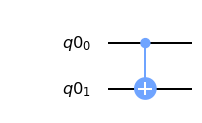

In [3]:
qc = QuantumCircuit(q)
qc.cx(q[0],q[1])
qc.draw('mpl')

In [4]:
job = execute(qc, backend)
job.result().get_unitary(qc, decimals=3)

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]])

#### Controlled $Y$ gate

Apply the $Y$ gate to the target qubit if the control qubit is the MSB

$$
C_Y = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & -i\\
0 & 0 & i & 0
\end{pmatrix},
$$

or when the LSB is the control

$$
C_Y = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 0 & 0 & -i\\
0 & 0 & 1 & 0\\
0 & i & 0 & 0
\end{pmatrix}.
$$

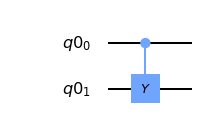

In [5]:
qc = QuantumCircuit(q)
qc.cy(q[0],q[1])
qc.draw('mpl')

In [6]:
job = execute(qc, backend)
job.result().get_unitary(qc, decimals=3)

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j]])

#### Controlled $Z$ (or, controlled Phase) gate

Similarly, the controlled Z gate flips the phase of the target qubit if the control qubit is $\left|1\right\rangle$. The matrix looks the same regardless of whether the MSB or LSB is the control qubit:

$$
C_Z = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & -1
\end{pmatrix}
$$



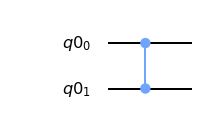

In [7]:
qc = QuantumCircuit(q)
qc.cz(q[0],q[1])
qc.draw('mpl')

In [8]:
job = execute(qc, backend)
job.result().get_unitary(qc, decimals=3)

array([[ 1.-0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.-0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.-0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]])

### Controlled Hadamard gate

Apply $H$ gate to the target qubit if the control qubit is $\left|1\right\rangle$. Below is the case where the control is the LSB qubit.

$$
C_H = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & \frac{1}{\sqrt{2}} & 0 & \frac{1}{\sqrt{2}}\\
0 & 0 & 1 & 0\\
0 & \frac{1}{\sqrt{2}}  & 0& -\frac{1}{\sqrt{2}}
\end{pmatrix}
$$

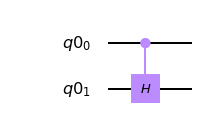

In [9]:
qc = QuantumCircuit(q)
qc.ch(q[0],q[1])
qc.draw('mpl')

In [10]:
job = execute(qc, backend)
job.result().get_unitary(qc, decimals=3)

array([[ 1.   -0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j],
       [ 0.   +0.j,  0.707+0.j,  0.   +0.j,  0.707-0.j],
       [ 0.   +0.j,  0.   +0.j,  1.   -0.j,  0.   +0.j],
       [ 0.   +0.j,  0.707+0.j,  0.   +0.j, -0.707+0.j]])

### Controlled phase rotation

Perform a phase rotation if both qubits are in the $\left|11\right\rangle$ state. The matrix looks the same regardless of whether the MSB or LSB is the control qubit.

$$
C_{u1}(\lambda) = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & e^{i\lambda}
\end{pmatrix}
$$

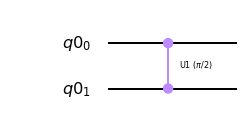

In [11]:
qc = QuantumCircuit(q)
qc.cu1(pi/2,q[0], q[1])
qc.draw('mpl')

In [12]:
job = execute(qc, backend)
job.result().get_unitary(qc, decimals=3)

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+1.j]])

### Controlled $u3$ rotation

Perform controlled-$u3$ rotation on the target qubit if the control qubit (here LSB) is $\left|1\right\rangle$. 

$$
C_{u3}(\theta, \phi, \lambda) \equiv 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & e^{-i(\phi+\lambda)/2}\cos(\theta/2) & 0 & -e^{-i(\phi-\lambda)/2}\sin(\theta/2)\\
0 & 0 & 1 & 0\\
0 & e^{i(\phi-\lambda)/2}\sin(\theta/2) & 0 & e^{i(\phi+\lambda)/2}\cos(\theta/2)
\end{pmatrix}.
$$

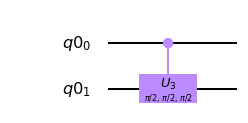

In [13]:
qc = QuantumCircuit(q)
qc.cu3(pi/2, pi/2, pi/2, q[0], q[1])
qc.draw('mpl')

In [14]:
job = execute(qc, backend)
job.result().get_unitary(qc, decimals=3)

array([[ 1.   +0.j   ,  0.   +0.j   ,  0.   +0.j   ,  0.   +0.j   ],
       [ 0.   +0.j   ,  0.707+0.j   ,  0.   +0.j   , -0.   -0.707j],
       [ 0.   +0.j   ,  0.   +0.j   ,  1.   +0.j   ,  0.   +0.j   ],
       [ 0.   +0.j   ,  0.   +0.707j,  0.   +0.j   , -0.707+0.j   ]])

### SWAP gate

The SWAP gate exchanges the two qubits. It transforms the basis vectors as

$$\left|00\right\rangle \rightarrow \left|00\right\rangle~,~\left|01\right\rangle \rightarrow \left|10\right\rangle~,~\left|10\right\rangle \rightarrow \left|01\right\rangle~,~\left|11\right\rangle \rightarrow \left|11\right\rangle,$$

which gives a matrix representation of the form

$$
\mathrm{SWAP} = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 1
\end{pmatrix}.
$$

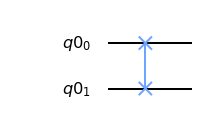

In [15]:
qc = QuantumCircuit(q)
qc.swap(q[0], q[1])
qc.draw('mpl')

In [16]:
job = execute(qc, backend)
job.result().get_unitary(qc, decimals=3)

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

# Multi-qubit states

In Dr. Farias' lectures, we have learned about Bell states, and how they can be generated using quantum gates. This section demonstrates how to create the Bell state $$\frac{1}{\sqrt{2}}\left(\vert00\rangle + \vert11\rangle\right)$$ from the state $\vert00\rangle$. We'll start by visualizing the state $\vert00\rangle$ using a procedure that you should already be familiar with *(assignment 0)*:

In [17]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere, plot_bloch_multivector

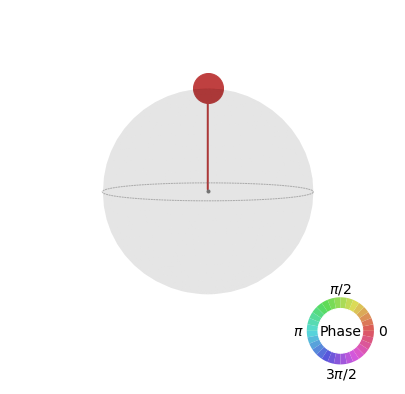

In [18]:
sv = Statevector.from_label('00')
plot_state_qsphere(sv.data)

Next, we use the Hadamard gate described above, along with a controlled-X gate, to create the Bell state. **This is the procedure we use to entagle two qubits**.

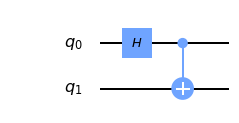

In [19]:
mycircuit = QuantumCircuit(2)
mycircuit.h(0)
mycircuit.cx(0,1)
mycircuit.draw('mpl')


The result of this quantum circuit on the state $\vert00\rangle$ is found by writing

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


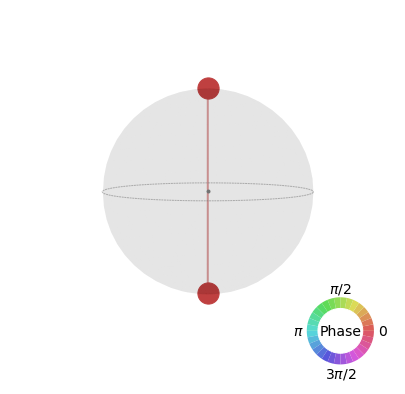

In [20]:
new_sv = sv.evolve(mycircuit)
print(new_sv)
plot_state_qsphere(new_sv.data)

Note how this looks very similar to a single-qubit superposition with zero phase. Following entanglement, it is no longer possible to treat the two qubits individually, and they must be considered to be one system. 

To see this clearly, we can see what would happen if we measured the Bell state above 1000 times.

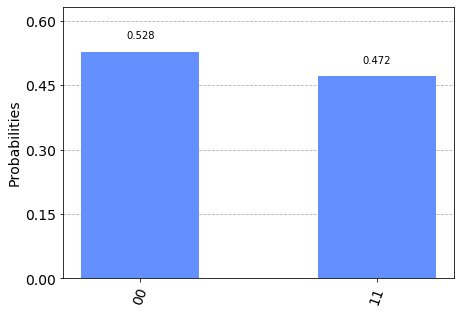

In [21]:
counts = new_sv.sample_counts(shots=1000)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

As you can see above, all measurements give either the result `00` or `11`. In other words, if the measurement outcome for one of the qubits is known, then the outcome for the other is fully determined.

# Measurements for Bell State

In the above example, we simulated the action of a measurement by sampling counts from the statevector. A measurement can explicitly be inserted into a quantum circuit as well. Here is an example that creates a different Bell state and applies a measurement.

In [ ]:
n_qbit = 2 #number of qubits used
n_cbit = n_qbit #number of classical bits needed to measure the qubits

mycircuit = QuantumCircuit(n_qbit, n_cbit)

qbit1 = 0 #index of qubit 1
qbit2 = 1 ##index of qubit 2

mycircuit.h(qbit1)
mycircuit.x(qbit2)
mycircuit.cx(qbit1,qbit2)
mycircuit.barrier()
mycircuit.measure([qbit1,qbit2], [qbit1,qbit2])
mycircuit.draw('mpl')

Two new features appeared in the circuit compared to our previous examples. 

- First, note that we used a second argument in the `QuantumCircuit(2,2)` command. The second argument says that we will be creating a quantum circuit that contains two qubits (the first argument), and two classical bits (the second argument).
- Second, note that the `measure` command takes two arguments. The first argument is the set of qubits that will be measured. The second is the set of classical bits onto which the outcomes from the measurements of the qubits will be stored.

Since the above quantum circuit contains non-unitaries (the measurement gates), we will use `Qiskit`'s built-in `Aer` simulators to run the circuit. To get the measurement counts, we can use the following code:

In [ ]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
result = execute(mycircuit, simulator, shots=10000).result()
counts = result.get_counts(mycircuit)
plot_histogram(counts)

As you can see, the measurement outcomes are similar to when we sampled counts from the statevector itself.

## Assignment 2.1

**What is the result of the measurements in the following circuit?**

<img src="bell.png" align="left" width="400"/>


**1)** 50% $\vert0\rangle$ and 50% $\vert1\rangle$

**2)** 50% $\vert00\rangle$ and 50% $\vert11\rangle$

**3)** 100% $\vert1\rangle$

**4)** Both 1 & 2 are possible

**5)** None of the above

The answer is option **(fill in)**

In [ ]:
## YOUR SOLUTION HERE ##

#recreate the circuit

#make the required measurement

#fire up the cicruit 10000 times (i.e. shots=10000)

#create the histogram of result

## Assignment 2.2 Quantum teleportation

In this exercise, you will teleport the quantum state 
$$\sqrt{0.70}\vert0\rangle + \sqrt{0.30}\vert1\rangle$$ from Alice's qubit to Bob's qubit. Recall that the teleportation algorithm consists of four major components:

1. Initializing the state to be teleported. We will do this on Alice's qubit `q0`.
2. Creating entanglement between two qubits. We will use qubits `q1` and `q2` for this. Recall that Alice owns `q1`, and Bob owns `q2`.
3. Applying a Bell measurement on Alice's qubits `q0` and `q1`.
4. Applying classically controlled operations on Bob's qubit `q2` depending on the outcomes of the Bell measurement on Alice's qubits.

This exercise guides you through each of these steps. Please read the sections **1.2 and 1.3** from the textbook in case of any confusion.

### Initializing the state to be teleported

First, create a quantum circuit that creates the state $$\sqrt{0.70}\vert0\rangle + \sqrt{0.30}\vert1\rangle$$ You can do this by using `Qiskit`'s `initialize` function, which takes in arguments - list of coefficients of states $\vert0\rangle and \vert1\rangle$ and *index of qubit*. The initialize method is a method of `QuantumCircuit` object, which in this example is the `given_circuit` variable

In [ ]:
def initialize_qubit(given_circuit, qubit_index):
    
    import numpy as np
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    
    #HINT: It is just one line long code (carefully read the cell on top of this)
    ### WRITE YOUR CODE BETWEEN THESE LINES - END
    
    return given_circuit

Next, we need to create entanglement between Alice's and Bob's qubits. To do this, think about which gates we need to use and *whose* qubits it needs to act on. 

In [ ]:
def entangle_qubits(given_circuit, qubit_Alice, qubit_Bob):
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END
    
    return given_circuit

Next, we need to do a Bell measurement of Alice's qubits. Think about how to create a bell measurement (see learning module).

In [ ]:
def bell_meas_Alice_qubits(given_circuit, qubit1_Alice, qubit2_Alice, clbit1_Alice, clbit2_Alice):
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    

    ### WRITE YOUR CODE BETWEEN THESE LINES - END

    
    return given_circuit

Finally, we apply controlled operations on Bob's qubit. Recall that the controlled operations are applied in this order:

- an $X$ gate is applied on Bob's qubit if the measurement coutcome of Alice's second qubit, `clbit2_Alice`, is `1`. (*I have done this for y'all*)
- a $Z$ gate is applied on Bob's qubit if the measurement coutcome of Alice's first qubit, `clbit1_Alice`, is `1`. (*Implement this*)

In [ ]:
def controlled_ops_Bob_qubit(given_circuit, qubit_Bob, clbit1_Alice, clbit2_Alice):
    
    given_circuit.x(qubit_Bob).c_if(clbit2_Alice, 1)
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END
    
    return given_circuit

The next lines of code put everything together. **You do not need to modify anything below, just run the cell to complete the assignment. Make sure you are understanding the logic of the code block**

In [ ]:
### imports
from qiskit import QuantumRegister, ClassicalRegister

### set up the qubits and classical bits
all_qubits_Alice = QuantumRegister(2)
all_qubits_Bob = QuantumRegister(1)
creg1_Alice = ClassicalRegister(1)
creg2_Alice = ClassicalRegister(1)

### quantum teleportation circuit here
# Initialize
mycircuit = QuantumCircuit(all_qubits_Alice, all_qubits_Bob, creg1_Alice, creg2_Alice)
initialize_qubit(mycircuit, 0)
mycircuit.barrier()
# Entangle
entangle_qubits(mycircuit, 1, 2)
mycircuit.barrier()
# Do a Bell measurement
bell_meas_Alice_qubits(mycircuit, all_qubits_Alice[0], all_qubits_Alice[1], creg1_Alice, creg2_Alice)
mycircuit.barrier()

# Apply classically controlled quantum gates
controlled_ops_Bob_qubit(mycircuit, all_qubits_Bob[0], creg1_Alice, creg2_Alice)

### Look at the complete circuit
print(mycircuit.draw(output='text'))

### store the circuit as the submitted answer
answer = mycircuit